In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
np.random.seed(42)
torch.manual_seed(42)

# Study population

In [3]:
data_dir = '/rds/general/user/sea22/ephemeral/datafiles/chexpert/CheXpert-v1.0/'
input_csv = 'chexpert.sample.train.csv'

# data_dir = '../datafiles/mimic/'
# input_csv = 'mimic.sample.test.csv'

output_suffix = 'resample'

sample_size_factor = 1

#### Preprocessing

In [4]:
df = pd.read_csv(data_dir + input_csv).drop(columns='Unnamed: 0')
print(df.groupby(["race"]).size())
def bin_age(age):
    if age <= 20:
        return 0
    if age <= 30:
        return 1
    if age <= 40:
        return 2
    if age <= 50:
        return 3
    if age <= 60:
        return 4
    if age <= 70:
        return 5
    if age <= 80:
        return 6
    return 7

df["age_bin"] = df["age"].apply(bin_age)

race
Asian    11371
Black     5596
White    59238
dtype: int64


#### Resample df to have equal proportion of Asian, Black, White

In [5]:
n_samples = len(df) * sample_size_factor
w_race = (1 / df.value_counts("race_label", normalize=True)).to_dict()
ids = list(torch.utils.data.WeightedRandomSampler(df["race_label"].apply(lambda x: w_race[x]).values, n_samples, replacement=True))
df_balanced_race = df.iloc[ids]
df_balanced_race.value_counts("race_label", normalize=True)

race_label
1    0.33465
0    0.33465
2    0.33070
dtype: float64

#### Within each (race)-subgroup  ensure equal prevalence. Within each (race, disease)-subsubgroup ensure equal age distribution.

In [6]:
subgroups = [df_balanced_race.loc[df_balanced_race["race_label"] == i] for i in df_balanced_race.race_label.unique()]
overall_proportion_disease = df.value_counts("disease_label", normalize=True)
disease_labels = df.disease_label.unique()

overall_proportion_age_per_disease_label = [df.loc[df.disease_label == d].value_counts("age_bin", normalize=True) for d in disease_labels]

for i, subgroup in enumerate(subgroups):
        
        # 1. Ensure constant disease prevalence in each subgroup
        n_samples = len(subgroup)
        observed_proportion = subgroup.value_counts("disease_label", normalize=True)
        w = (overall_proportion_disease / observed_proportion).to_dict()
        ids = list(torch.utils.data.WeightedRandomSampler(subgroup["disease_label"].apply(lambda x: w[x]).values, n_samples, replacement=True))
        subgroups[i] = subgroup.iloc[ids]

        # 2. Further ensure constant age repartition across groups
        subsubgroups = [subgroups[i].loc[subgroups[i].disease_label == d] for d in disease_labels]
        for j, subsubgroup in enumerate(subsubgroups): 
                n_samples = len(subsubgroup)
                observed_proportion = subsubgroup.value_counts("age_bin", normalize=True)
                w = (overall_proportion_age_per_disease_label[j] / observed_proportion).to_dict()
                ids = list(torch.utils.data.WeightedRandomSampler(subsubgroup["age_bin"].apply(lambda x: w[x]).values, n_samples, replacement=True))
                subsubgroups[j] = subsubgroup.iloc[ids]

        subgroups[i] = pd.concat(subsubgroups)
        
balanced_df = pd.concat(subgroups)

#### Check balanced dataset

In [7]:
balanced_df.groupby(["race"]).size()

race
Asian    25502
Black    25201
White    25502
dtype: int64

In [8]:
balanced_df.groupby(["race", "disease_label"]).size()

race   disease_label
Asian  0                 2230
       1                10230
       2                13042
Black  0                 2160
       1                10225
       2                12816
White  0                 2172
       1                10261
       2                13069
dtype: int64

In [9]:
balanced_df.groupby(["race", "disease_label", "age_bin"]).size()

race   disease_label  age_bin
Asian  0              0            58
                      1           195
                      2           240
                      3           338
                      4           527
                                 ... 
White  2              3          1402
                      4          2518
                      5          2919
                      6          2388
                      7          2307
Length: 72, dtype: int64

#### Save balanced dataset

In [10]:
balanced_df.to_csv(data_dir + input_csv.replace('sample',output_suffix))

## Plots

In [11]:
df_cxr = pd.read_csv(data_dir + input_csv.replace('sample',output_suffix))

In [12]:
df_cxr.loc[df_cxr['disease'] == 'Pleural Effusion', 'disease'] = 'Pleur. Eff.'
df_cxr.loc[df_cxr['disease'] == 'No Finding', 'disease'] = 'No Find.'

In [13]:
df_subgroup = df_cxr[df_cxr['race_label']==0]
prev_0 = len(df_subgroup[df_subgroup['disease_label']==0]) / len(df_subgroup)
prev_1 = len(df_subgroup[df_subgroup['disease_label']==1]) / len(df_subgroup)
prev_2 = len(df_subgroup[df_subgroup['disease_label']==2]) / len(df_subgroup)
print('')
print('Prevalence - White')
print('No-finding:\t\t{:.2f}'.format(prev_0))
print('Pleural effusion:\t{:.2f}'.format(prev_1))
print('Other:\t\t\t{:.2f}'.format(prev_2))

df_subgroup = df_cxr[df_cxr['race_label']==1]
prev_0 = len(df_subgroup[df_subgroup['disease_label']==0]) / len(df_subgroup)
prev_1 = len(df_subgroup[df_subgroup['disease_label']==1]) / len(df_subgroup)
prev_2 = len(df_subgroup[df_subgroup['disease_label']==2]) / len(df_subgroup)
print('')
print('Prevalence - Asian')
print('No-finding:\t\t{:.2f}'.format(prev_0))
print('Pleural effusion:\t{:.2f}'.format(prev_1))
print('Other:\t\t\t{:.2f}'.format(prev_2))

df_subgroup = df_cxr[df_cxr['race_label']==2]
prev_0 = len(df_subgroup[df_subgroup['disease_label']==0]) / len(df_subgroup)
prev_1 = len(df_subgroup[df_subgroup['disease_label']==1]) / len(df_subgroup)
prev_2 = len(df_subgroup[df_subgroup['disease_label']==2]) / len(df_subgroup)
print('')
print('Prevalence - Black')
print('No-finding:\t\t{:.2f}'.format(prev_0))
print('Pleural effusion:\t{:.2f}'.format(prev_1))
print('Other:\t\t\t{:.2f}'.format(prev_2))


Prevalence - White
No-finding:		0.09
Pleural effusion:	0.40
Other:			0.51

Prevalence - Asian
No-finding:		0.09
Pleural effusion:	0.40
Other:			0.51

Prevalence - Black
No-finding:		0.09
Pleural effusion:	0.41
Other:			0.51


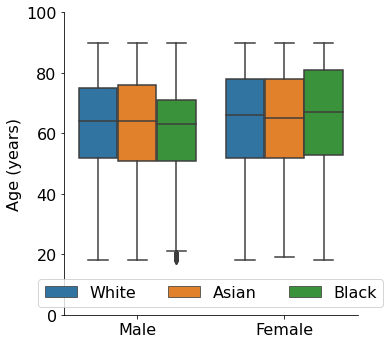

In [14]:
fontsize = 16
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)

fig = sns.catplot(x='sex', y='age', hue='race', order=['Male', 'Female'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()
# fig.savefig("CheXpert-resample-age-sex-race.png", bbox_inches='tight', dpi=300)

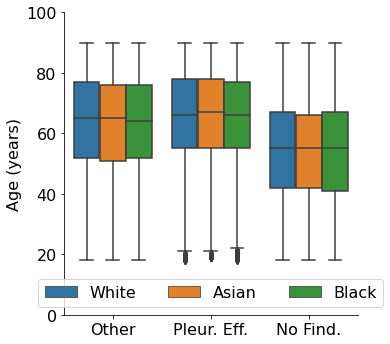

In [15]:
fig = sns.catplot(x='disease', y='age', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()
# fig.savefig("CheXpert-resample-age-pathology-race.png", bbox_inches='tight', dpi=300)

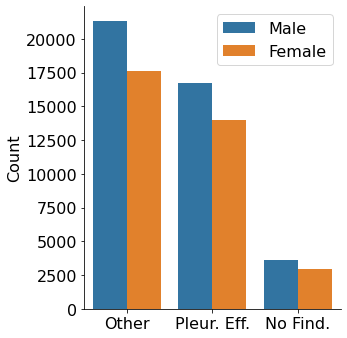

In [16]:
fig = sns.catplot(x='disease', hue='sex', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['Male', 'Female'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-sex-pathology.png", bbox_inches='tight', dpi=300)

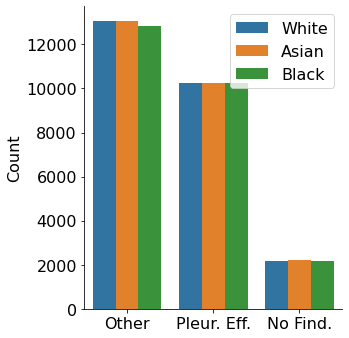

In [17]:
fig = sns.catplot(x='disease', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-race-pathology.png", bbox_inches='tight', dpi=300)

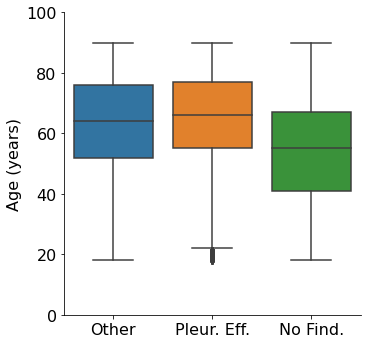

In [18]:
fig = sns.catplot(x='disease', y='age', order=['Other', 'Pleur. Eff.', 'No Find.'], kind="box", data=df_cxr)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("CheXpert-resample-age-pathology.png", bbox_inches='tight', dpi=300)

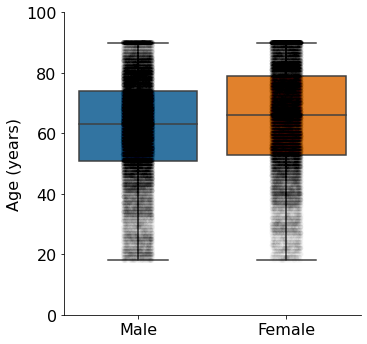

In [19]:
fig = sns.catplot(x='sex', y='age', order=['Male', 'Female'], kind="box", data=df_cxr)
sns.stripplot(x='sex', y='age', color='k', order=['Male', 'Female'], alpha=0.01, data=df_cxr, ax=fig.ax)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("CheXpert-resample-age-sex.png", bbox_inches='tight', dpi=300)

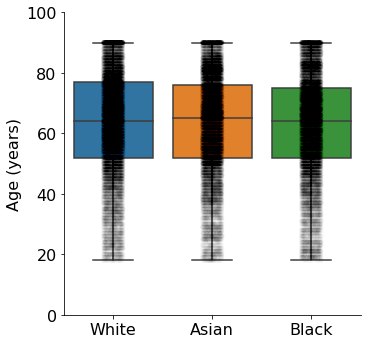

In [20]:
fig = sns.catplot(x='race', y='age', order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
sns.stripplot(x='race', y='age', color='k', order=['White', 'Asian', 'Black'], alpha=0.01, data=df_cxr, ax=fig.ax)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("CheXpert-resample-age-race.png", bbox_inches='tight', dpi=300)

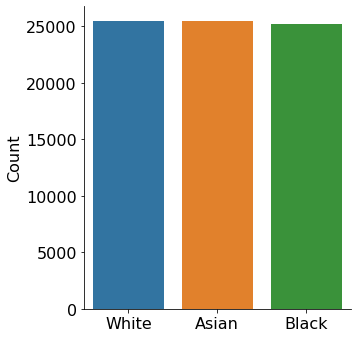

In [21]:
fig = sns.catplot(x='race', order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-race.png", bbox_inches='tight', dpi=300)

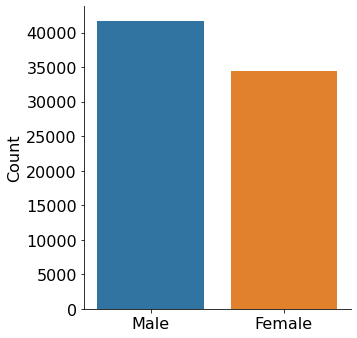

In [22]:
fig = sns.catplot(x='sex', order=['Male', 'Female'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-sex.png", bbox_inches='tight', dpi=300)

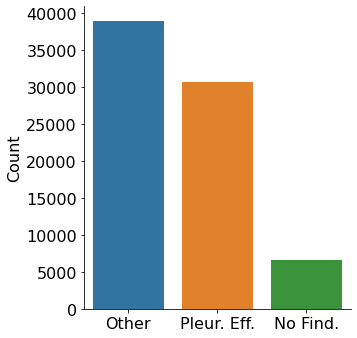

In [23]:
fig = sns.catplot(x='disease', order=['Other', 'Pleur. Eff.', 'No Find.'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-pathology.png", bbox_inches='tight', dpi=300)

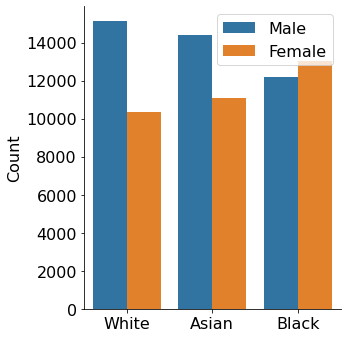

In [24]:
fig = sns.catplot(x='race', hue='sex', order=['White', 'Asian', 'Black'], hue_order=['Male', 'Female'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-sex-race.png", bbox_inches='tight', dpi=300)

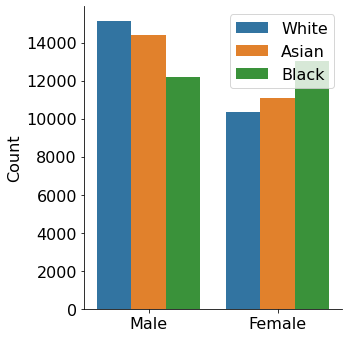

In [25]:
fig = sns.catplot(x='sex', hue='race', order=['Male', 'Female'], hue_order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("CheXpert-resample-race-sex.png", bbox_inches='tight', dpi=300)